<a href="https://colab.research.google.com/github/MujeebShinwari/Fundus_CIMT_2903_Classfication_using_RetFound_and_-EfficientNetV2_models/blob/main/Fundus_CIMT_2903_Classfication_using_RetFound_and_EfficientNetV2_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Setup and Installation
!pip install torch torchvision torchmetrics pytorch-lightning timm efficientnet-pytorch
!pip install matplotlib seaborn scikit-learn pandas

from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from efficientnet_pytorch import EfficientNet

# Set random seeds for reproducibility
pl.seed_everything(42)
print("All packages installed and imports done!")

Mounted at /content/drive


INFO:lightning_fabric.utilities.seed:Seed set to 42


All packages installed and imports done!


In [3]:
# Cell 2: Data Preparation
dataset_path = "/content/drive/MyDrive/Fundus_CIMT_2903_Dataset"
data_dir = os.path.join(dataset_path, "data")
json_path = os.path.join(dataset_path, "data_info.json")

# Load the JSON file
with open(json_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to a pandas DataFrame
records = []
for patient_id, data in metadata.items():
    for eye in ['right_eye', 'left_eye']:
        if data[eye]:
            records.append({
                'patient_id': patient_id,
                'eye': eye.split('_')[0],
                'image_path': os.path.join(data_dir, data[eye]),
                'gender': data['gender'],
                'thickness': data['thickness'],
                'label': data['label'],
                'group': data['group'],
                'true_age': data['True_age'],
                'age': data['age']
            })

df = pd.DataFrame(records)

# For quick testing, use only 10% of the data
# COMMENT OUT THE NEXT LINE TO USE FULL DATASET
df = df.sample(frac=0.1, random_state=42)

print(f"Total samples in dataset: {len(df)}")
print("\nFirst 5 samples:")
print(df.head())
print("\nDataset summary:")
print(df.describe())

# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())

Total samples in dataset: 581

First 5 samples:
     patient_id    eye                                         image_path  \
501   200680003   left  /content/drive/MyDrive/Fundus_CIMT_2903_Datase...   
3162  513810002  right  /content/drive/MyDrive/Fundus_CIMT_2903_Datase...   
3782  549118001  right  /content/drive/MyDrive/Fundus_CIMT_2903_Datase...   
4274  580761001  right  /content/drive/MyDrive/Fundus_CIMT_2903_Datase...   
4897  640295001   left  /content/drive/MyDrive/Fundus_CIMT_2903_Datase...   

      gender  thickness  label  group  true_age       age  
501        1        0.9      1      1        38  0.342466  
3162       1        1.0      1      1        35  0.301370  
3782       0        0.8      0      1        22  0.123288  
4274       1        0.7      0      1        33  0.273973  
4897       0        0.7      0      1        23  0.136986  

Dataset summary:
           gender   thickness       label       group    true_age         age
count  581.000000  581.000000  58

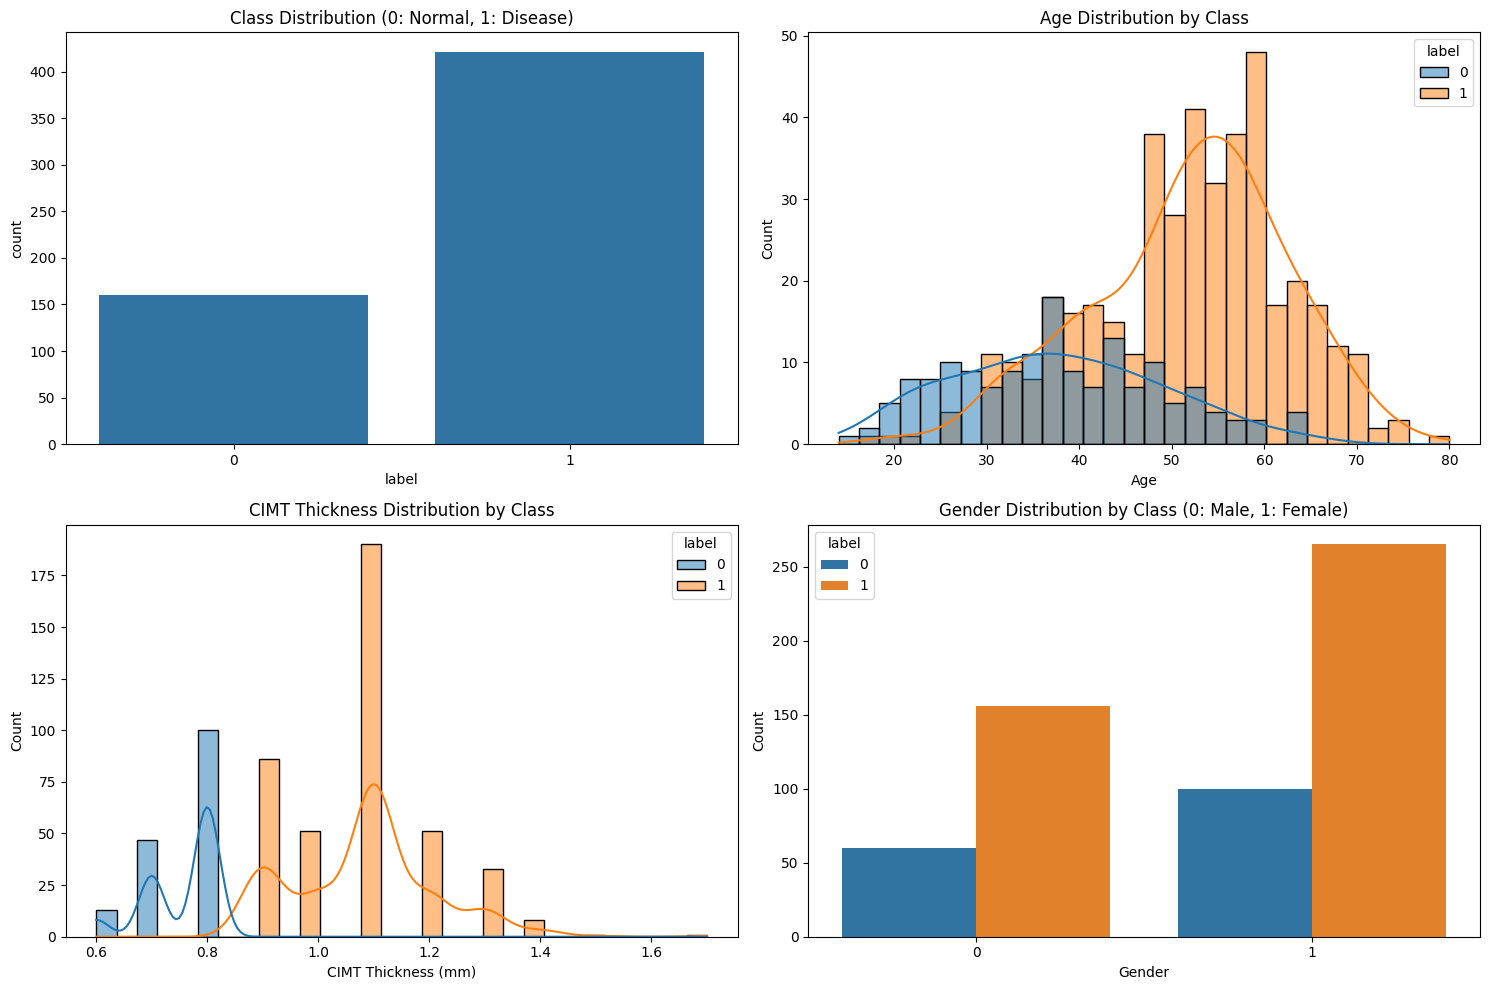


Sample images from dataset:


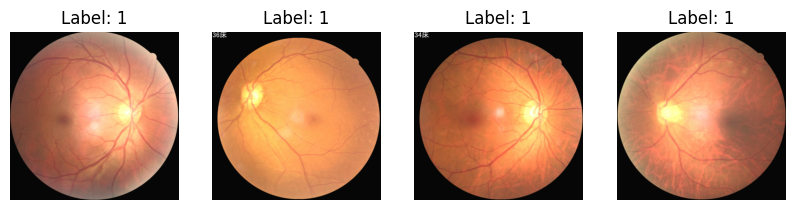

In [4]:
# Cell 3: Data Visualization
plt.figure(figsize=(15, 10))

# Class distribution
plt.subplot(2, 2, 1)
sns.countplot(x='label', data=df)
plt.title('Class Distribution (0: Normal, 1: Disease)')

# Age distribution by class
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='true_age', hue='label', kde=True, bins=30)
plt.title('Age Distribution by Class')
plt.xlabel('Age')
plt.ylabel('Count')

# Thickness distribution
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='thickness', hue='label', kde=True, bins=30)
plt.title('CIMT Thickness Distribution by Class')
plt.xlabel('CIMT Thickness (mm)')
plt.ylabel('Count')

# Gender distribution by class
plt.subplot(2, 2, 4)
sns.countplot(data=df, x='gender', hue='label')
plt.title('Gender Distribution by Class (0: Male, 1: Female)')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print some sample images
print("\nSample images from dataset:")
sample_images = df.sample(4, random_state=42)['image_path'].values

plt.figure(figsize=(10, 5))
for i, img_path in enumerate(sample_images):
    img = plt.imread(img_path)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {df[df['image_path'] == img_path]['label'].values[0]}")
plt.show()

In [5]:
# Cell 4: Dataset and DataLoader Creation
from PIL import Image

class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['label'], dtype=torch.long)
        thickness = torch.tensor(row['thickness'], dtype=torch.float32)
        age = torch.tensor(row['age'], dtype=torch.float32)
        gender = torch.tensor(row['gender'], dtype=torch.float32)

        return image, label, thickness, age, gender

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Create datasets and dataloaders
train_dataset = FundusDataset(train_df, transform=train_transform)
val_dataset = FundusDataset(val_df, transform=val_transform)
test_dataset = FundusDataset(test_df, transform=val_transform)

# For quick testing, use smaller batch size
# INCREASE BATCH SIZE FOR FULL DATASET (e.g., 32 or 64)
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print one batch to verify
sample_batch = next(iter(train_loader))
print("\nSample batch shapes:")
print(f"Images: {sample_batch[0].shape}")
print(f"Labels: {sample_batch[1].shape}")
print(f"Thickness: {sample_batch[2].shape}")
print(f"Age: {sample_batch[3].shape}")
print(f"Gender: {sample_batch[4].shape}")

Train size: 406
Validation size: 87
Test size: 88

Sample batch shapes:
Images: torch.Size([8, 3, 512, 512])
Labels: torch.Size([8])
Thickness: torch.Size([8])
Age: torch.Size([8])
Gender: torch.Size([8])


In [6]:
# Cell 5: Model Definitions
class RetFoundModel(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(RetFoundModel, self).__init__()
        self.base_model = models.resnet50(pretrained=pretrained)
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class EfficientNetV2Model(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(EfficientNetV2Model, self).__init__()
        if pretrained:
            self.base_model = EfficientNet.from_pretrained('efficientnet-b7')
        else:
            self.base_model = EfficientNet.from_name('efficientnet-b7')
        num_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Test model with sample input
print("Testing model architectures...")
sample_input = torch.randn(1, 3, 512, 512)

retfound = RetFoundModel()
effnet = EfficientNetV2Model()

print("\nRetFound output shape:", retfound(sample_input).shape)
print("EfficientNetV2 output shape:", effnet(sample_input).shape)
print("\nModel architectures verified!")

Testing model architectures...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|████

Loaded pretrained weights for efficientnet-b7

RetFound output shape: torch.Size([1, 2])
EfficientNetV2 output shape: torch.Size([1, 2])

Model architectures verified!


In [7]:
# Cell 6: Training Setup
class FundusClassifier(pl.LightningModule):
    def __init__(self, model_name='retfound', learning_rate=1e-4):
        super().__init__()
        self.learning_rate = learning_rate

        if model_name == 'retfound':
            self.model = RetFoundModel()
        elif model_name == 'efficientnet':
            self.model = EfficientNetV2Model()
        else:
            raise ValueError("Invalid model name")

        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        self.test_acc = torchmetrics.Accuracy(task='binary')

        self.train_auc = torchmetrics.AUROC(task='binary')
        self.val_auc = torchmetrics.AUROC(task='binary')
        self.test_auc = torchmetrics.AUROC(task='binary')

        self.train_f1 = torchmetrics.F1Score(task='binary')
        self.val_f1 = torchmetrics.F1Score(task='binary')
        self.test_f1 = torchmetrics.F1Score(task='binary')

        # For storing predictions
        self.test_preds = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, _, _, _ = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        self.train_auc(logits[:, 1], y)
        self.train_f1(preds, y)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_auc', self.train_auc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _, _, _ = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        self.val_auc(logits[:, 1], y)
        self.val_f1(preds, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_auc', self.val_auc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, _, _, _ = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, y)
        self.test_auc(logits[:, 1], y)
        self.test_f1(preds, y)

        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(y.cpu().numpy())

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_auc', self.test_auc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.test_f1, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.1, patience=3, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_auc',
                'interval': 'epoch',
                'frequency': 1
            }
        }

print("Training setup complete!")

Training setup complete!


In [8]:
# Cell 7: Training RetFound Model
# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_auc',
    dirpath='./checkpoints',
    filename='retfound-{epoch:02d}-{val_auc:.2f}',
    save_top_k=1,
    mode='max'
)

# Initialize model
retfound_model = FundusClassifier(model_name='retfound')

# Trainer
# FOR FULL DATASET, INCREASE MAX_EPOCHS (e.g., 20-30)
trainer = pl.Trainer(
    max_epochs=5,  # Reduced for quick testing
    callbacks=[early_stopping, checkpoint_callback],
    accelerator='auto',
    devices=1 if torch.cuda.is_available() else None,
    log_every_n_steps=5,
    deterministic=True
)

print("Starting RetFound training...")
trainer.fit(retfound_model, train_loader, val_loader)

print("\nRetFound training complete! Testing...")
trainer.test(retfound_model, dataloaders=test_loader)

TypeError: `devices` selected with `CPUAccelerator` should be an int > 0.

In [24]:
# Cell 8: Training EfficientNetV2 Model
# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_auc',
    dirpath='./checkpoints',
    filename='efficientnet-{epoch:02d}-{val_auc:.2f}',
    save_top_k=1,
    mode='max'
)

# Initialize model
efficientnet_model = FundusClassifier(model_name='efficientnet')

# Trainer
# FOR FULL DATASET, INCREASE MAX_EPOCHS (e.g., 20-30)
trainer = pl.Trainer(
    max_epochs=5,  # Reduced for quick testing
    callbacks=[early_stopping, checkpoint_callback],
    accelerator='auto',
    devices=1 if torch.cuda.is_available() else None,
    log_every_n_steps=5,
    deterministic=True
)

print("Starting EfficientNetV2 training...")
trainer.fit(efficientnet_model, train_loader, val_loader)

print("\nEfficientNetV2 training complete! Testing...")
trainer.test(efficientnet_model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type                | Params | Mode 
-----------------------------------------------------------
0  | model     | EfficientNetV2Model | 63.8 M | train
1  | criterion | CrossEntropyLoss    | 0      | train
2  | train_acc | BinaryAccuracy      | 0      | train
3  | val_acc   | BinaryAccuracy      | 0      | train
4  | test_acc  | BinaryAccuracy      | 0      | train
5  | train_auc | BinaryAUROC         | 0      | train
6  | val_auc   | BinaryAUROC         | 0      | train
7  | test_auc  | BinaryAUROC         | 0      | train
8  | train_f1  | BinaryF1Score       | 0      | train
9  | val_f1    | BinaryF

Loaded pretrained weights for efficientnet-b7
Starting EfficientNetV2 training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 24.12 MiB is free. Process 12291 has 14.71 GiB memory in use. Of the allocated memory 14.47 GiB is allocated by PyTorch, and 61.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Cell 9: Evaluation and Comparison
def evaluate_model(model, model_name):
    # Confusion matrix
    cm = confusion_matrix(model.test_labels, model.test_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Disease'],
                yticklabels=['Normal', 'Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Classification report
    print(f"\n{classification_report(model.test_labels, model.test_preds, target_names=['Normal', 'Disease'])}")

    # ROC Curve
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            x, y, _, _, _ = batch
            logits = model(x)
            probs = torch.softmax(logits, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': model.test_acc.compute().item(),
        'auc': model.test_auc.compute().item(),
        'f1': model.test_f1.compute().item(),
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr, roc_auc)
    }

print("Evaluating RetFound...")
retfound_metrics = evaluate_model(retfound_model, 'RetFound')

print("\nEvaluating EfficientNetV2...")
efficientnet_metrics = evaluate_model(efficientnet_model, 'EfficientNetV2')

# Comparison
comparison_df = pd.DataFrame({
    'Model': ['RetFound', 'EfficientNetV2'],
    'Accuracy': [retfound_metrics['accuracy'], efficientnet_metrics['accuracy']],
    'AUC': [retfound_metrics['auc'], efficientnet_metrics['auc']],
    'F1 Score': [retfound_metrics['f1'], efficientnet_metrics['f1']]
})

print("\nModel Comparison:")
print(comparison_df)

plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'AUC', 'F1 Score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, comparison_df.iloc[0, 1:], width, label='RetFound')
rects2 = ax.bar(x + width/2, comparison_df.iloc[1, 1:], width, label='EfficientNetV2')

ax.set_ylabel('Score')
ax.set_title('Model Comparison by Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

best_model = 'RetFound' if retfound_metrics['auc'] > efficientnet_metrics['auc'] else 'EfficientNetV2'
print(f"\nThe better performing model is: {best_model}")

In [ ]:
# Cell 10: RetFound Prediction on User-Uploaded Image
from google.colab import files
from PIL import Image
import torch.nn.functional as F

def predict_retfound(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(retfound_model.device)

    # Predict
    retfound_model.eval()
    with torch.no_grad():
        logits = retfound_model(img_tensor)
        probs = F.softmax(logits, dim=1)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uploaded Fundus Image')

    plt.subplot(1, 2, 2)
    plt.bar(['Normal (CIMT < 0.9)', 'Disease (CIMT ≥ 0.9)'], probs.cpu().numpy()[0], color=['green', 'red'])
    plt.title(f'RetFound Prediction\nDisease Probability: {probs[0][1].item():.2%}')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

# Upload and predict
print("Please upload a fundus image for RetFound prediction")
uploaded = files.upload()
for filename in uploaded.keys():
    predict_retfound(filename)

In [ ]:
# Cell 11: EfficientNetV2 Prediction on User-Uploaded Image
def predict_efficientnet(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(efficientnet_model.device)

    # Predict
    efficientnet_model.eval()
    with torch.no_grad():
        logits = efficientnet_model(img_tensor)
        probs = F.softmax(logits, dim=1)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uploaded Fundus Image')

    plt.subplot(1, 2, 2)
    plt.bar(['Normal (CIMT < 0.9)', 'Disease (CIMT ≥ 0.9)'], probs.cpu().numpy()[0], color=['green', 'red'])
    plt.title(f'EfficientNetV2 Prediction\nDisease Probability: {probs[0][1].item():.2%}')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

# Upload and predict
print("Please upload the same fundus image for EfficientNetV2 prediction")
uploaded = files.upload()
for filename in uploaded.keys():
    predict_efficientnet(filename)